# Siemens Energy Coding Challenge - Task 1 - 2021 - Sam MacIntyre

This jupyter notebook contains the code related to task 1, the jupyter notebook follows the structure below:

- Task outline
- Environment and version control
- Problem approach
- Data and library loading
- Data exploration and summary statistics
- Temporal alignment
- NAN treatment
- Moving average predictions
- Reproduce plots
- Conclusions and discussion


## Task outline

Time series data is often coming in different granularities and different frequencies. More often than not, we try to forecast or predict a timeseries value based on the historical observations of this time series as well as its causal dependency with another time series.
In this task you should use the file task1_60min_singleindex_filtered.csv to write a data processing pipeline that is able to:

- Temporally align the timeseries signals (please refer to the plots folder for a visual representation);
- Deal with the NAN values within the data, using methods up to your decision;
- Generate moving average hourly predictions up to 7 days into the future;
- Reproduce the plots provided after replacing the missing values and generating the predictions.

If you don't have sufficient computer power to use the whole dataset in the predictors generation part, feel free to use a subset of the data.

## Environment and version control

A temporary Github repository will be used to employ version control and protect against loss of code. Furthermore, a standard Python3 venv has been set up to ensure a clean and reproducible coding environment.

## Import libraries

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

## Load data

In [296]:
# Data loading
df_ts = pd.read_csv('data/Task 1/task1_60min_singleindex_filtered.csv', encoding = 'latin-1')

## Data exploration

In [297]:
# Check head of data to ensure proper reading
df_ts.head()

,utc_timestamp,cet_cest_timestamp,SE_load_actual_entsoe_power_statistics,SE_load_actual_entsoe_transparency,SE_load_actual_tso,SE_load_forecast_entsoe_transparency,SE_price_day_ahead,SE_solar_generation_actual,SE_wind_generation_actual,SE_wind_onshore_generation_actual,...,SE_2_price_day_ahead,SE_2_wind_onshore_generation_actual,SE_3_load_actual_entsoe_transparency,SE_3_load_forecast_entsoe_transparency,SE_3_price_day_ahead,SE_3_wind_onshore_generation_actual,SE_4_load_actual_entsoe_transparency,SE_4_load_forecast_entsoe_transparency,SE_4_price_day_ahead,SE_4_wind_onshore_generation_actual
0,2004-12-31T23:00:00Z,2005-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-01T00:00:00Z,2005-01-01T01:00:00+0100,NaN,NaN,-15991.34,NaN,NaN,NaN,3.22,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-01-01T01:00:00Z,2005-01-01T02:00:00+0100,NaN,NaN,-15673.12,NaN,NaN,NaN,2.84,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-01-01T02:00:00Z,2005-01-01T03:00:00+0100,NaN,NaN,-15431.81,NaN,NaN,NaN,2.57,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-01-01T03:00:00Z,2005-01-01T04:00:00+0100,NaN,NaN,-15326.48,NaN,NaN,NaN,3.12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [298]:
# Check column types
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125593 entries, 0 to 125592
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   utc_timestamp                           125593 non-null  object 
 1   cet_cest_timestamp                      125593 non-null  object 
 2   SE_load_actual_entsoe_power_statistics  78886 non-null   float64
 3   SE_load_actual_entsoe_transparency      37847 non-null   float64
 4   SE_load_actual_tso                      122710 non-null  float64
 5   SE_load_forecast_entsoe_transparency    37798 non-null   float64
 6   SE_price_day_ahead                      51112 non-null   float64
 7   SE_solar_generation_actual              74538 non-null   float64
 8   SE_wind_generation_actual               122710 non-null  float64
 9   SE_wind_onshore_generation_actual       38038 non-null   float64
 10  SE_1_load_actual_entsoe_transparency    3829

#### Summary statistics

In [299]:
df_ts.describe()

,SE_load_actual_entsoe_power_statistics,SE_load_actual_entsoe_transparency,SE_load_actual_tso,SE_load_forecast_entsoe_transparency,SE_price_day_ahead,SE_solar_generation_actual,SE_wind_generation_actual,SE_wind_onshore_generation_actual,SE_1_load_actual_entsoe_transparency,SE_1_load_forecast_entsoe_transparency,...,SE_2_price_day_ahead,SE_2_wind_onshore_generation_actual,SE_3_load_actual_entsoe_transparency,SE_3_load_forecast_entsoe_transparency,SE_3_price_day_ahead,SE_3_wind_onshore_generation_actual,SE_4_load_actual_entsoe_transparency,SE_4_load_forecast_entsoe_transparency,SE_4_price_day_ahead,SE_4_wind_onshore_generation_actual
count,78886.000000,37847.000000,122710.000000,37798.000000,51112.000000,74538.000000,122710.000000,38038.000000,38297.000000,38182.000000,...,38302.000000,38038.000000,38297.000000,38182.000000,65053.000000,38038.000000,38297.000000,38182.000000,65053.000000,38038.000000
mean,15943.027547,15836.095595,-15537.850302,15943.467908,45.395782,2021.479640,905.527857,1934.760529,1123.080411,1122.235085,...,32.283894,626.044534,10034.535838,10078.097402,33.489742,679.026145,2794.826227,2814.631057,34.479852,456.365634
std,3507.769553,3408.919933,3462.560429,3394.720625,25.475342,5695.203685,1016.760651,1163.683425,208.816034,188.281996,...,13.113148,493.357386,2214.678565,2202.289660,12.831325,477.844937,668.553302,670.919466,13.799146,346.393558
min,8722.000000,8619.000000,-26265.307690,8911.000000,0.000000,0.000000,0.000000,18.000000,368.000000,711.000000,...,0.320000,0.000000,5212.000000,5336.000000,0.320000,2.000000,436.000000,1345.000000,0.320000,1.000000
25%,13204.000000,13177.000000,-17966.530958,13272.000000,34.650000,0.010000,142.830000,997.000000,965.000000,968.000000,...,24.160000,212.000000,8298.000000,8347.250000,26.200000,285.000000,2283.000000,2295.000000,26.540000,171.000000
50%,15538.000000,15484.000000,-15183.670471,15622.500000,43.190000,0.064862,519.021556,1748.000000,1106.000000,1110.000000,...,30.210000,493.000000,9825.000000,9895.000000,32.060000,578.000000,2744.000000,2761.000000,32.590000,362.000000
75%,18365.000000,18231.000000,-12816.349851,18350.750000,54.020000,2.893641,1333.253753,2670.000000,1263.000000,1265.000000,...,40.147500,973.000000,11601.000000,11647.000000,39.710000,977.000000,3263.000000,3288.000000,40.940000,680.000000
max,27380.000000,26714.000000,-8016.770000,26416.000000,1400.110000,26731.623710,5874.000968,6250.000000,3965.000000,3272.000000,...,255.020000,2093.000000,17677.000000,16957.000000,255.020000,2257.000000,4921.000000,5014.000000,255.020000,1475.000000


Some initial comments from inspection of data:
- Two timestamps present, one in UTC time and the other in CET
- Both timestamps **not** in datetime format
- 23 individual timeseries present, 2 of which not in floating point format
- Timeseries are of different lengths and have different number of NANs


#### Convert to floats

In [300]:
# Convert from object type to float type
df_ts['SE_2_price_day_ahead'] = pd.to_numeric(df_ts['SE_2_price_day_ahead'])

#### Comments

- Manually had to fix a number containing an erroneous letter

#### Treating timestamps

In [301]:
# Convert timestamps
df_ts['utc_timestamp'] = pd.to_datetime(df_ts['utc_timestamp'])

In [302]:
df_ts['cet_cest_timestamp'] = pd.to_datetime(df_ts['cet_cest_timestamp'])

**Comments**:

Three timestamps had to treated manually as they had errors:

1. timestamp contained #
2. í special character in timestamp
3. 3019 instead of 2019 present in timestamp

In [303]:
# Check timestamps
df_ts.head()

,utc_timestamp,cet_cest_timestamp,SE_load_actual_entsoe_power_statistics,SE_load_actual_entsoe_transparency,SE_load_actual_tso,SE_load_forecast_entsoe_transparency,SE_price_day_ahead,SE_solar_generation_actual,SE_wind_generation_actual,SE_wind_onshore_generation_actual,...,SE_2_price_day_ahead,SE_2_wind_onshore_generation_actual,SE_3_load_actual_entsoe_transparency,SE_3_load_forecast_entsoe_transparency,SE_3_price_day_ahead,SE_3_wind_onshore_generation_actual,SE_4_load_actual_entsoe_transparency,SE_4_load_forecast_entsoe_transparency,SE_4_price_day_ahead,SE_4_wind_onshore_generation_actual
0,2004-12-31 23:00:00+00:00,2005-01-01 00:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-01 00:00:00+00:00,2005-01-01 01:00:00+01:00,NaN,NaN,-15991.34,NaN,NaN,NaN,3.22,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-01-01 01:00:00+00:00,2005-01-01 02:00:00+01:00,NaN,NaN,-15673.12,NaN,NaN,NaN,2.84,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-01-01 02:00:00+00:00,2005-01-01 03:00:00+01:00,NaN,NaN,-15431.81,NaN,NaN,NaN,2.57,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-01-01 03:00:00+00:00,2005-01-01 04:00:00+01:00,NaN,NaN,-15326.48,NaN,NaN,NaN,3.12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [304]:
# drop one of the timestamps and put the other as an index
df_ts.drop('cet_cest_timestamp', axis = 1, inplace = True)

In [305]:
# set timestamp as index
df_ts.set_index('utc_timestamp', inplace = True)

In [306]:
df_ts

,SE_load_actual_entsoe_power_statistics,SE_load_actual_entsoe_transparency,SE_load_actual_tso,SE_load_forecast_entsoe_transparency,SE_price_day_ahead,SE_solar_generation_actual,SE_wind_generation_actual,SE_wind_onshore_generation_actual,SE_1_load_actual_entsoe_transparency,SE_1_load_forecast_entsoe_transparency,...,SE_2_price_day_ahead,SE_2_wind_onshore_generation_actual,SE_3_load_actual_entsoe_transparency,SE_3_load_forecast_entsoe_transparency,SE_3_price_day_ahead,SE_3_wind_onshore_generation_actual,SE_4_load_actual_entsoe_transparency,SE_4_load_forecast_entsoe_transparency,SE_4_price_day_ahead,SE_4_wind_onshore_generation_actual
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2004-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 00:00:00+00:00,NaN,NaN,-15991.34,NaN,NaN,NaN,3.22,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 01:00:00+00:00,NaN,NaN,-15673.12,NaN,NaN,NaN,2.84,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 02:00:00+00:00,NaN,NaN,-15431.81,NaN,NaN,NaN,2.57,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 03:00:00+00:00,NaN,NaN,-15326.48,NaN,NaN,NaN,3.12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-30 19:00:00+00:00,NaN,13463.0,NaN,14846.0,NaN,NaN,NaN,1343.0,900.0,1160.0,...,40.66,782.0,8749.0,9548.0,NaN,217.0,2389.0,2449.0,NaN,87.0
2019-04-30 20:00:00+00:00,NaN,12928.0,NaN,14164.0,NaN,NaN,NaN,1583.0,774.0,1122.0,...,38.96,894.0,8347.0,9038.0,NaN,266.0,2239.0,2357.0,NaN,98.0
2019-04-30 21:00:00+00:00,NaN,12110.0,NaN,13336.0,NaN,NaN,NaN,1709.0,715.0,1105.0,...,5.03,914.0,7881.0,8426.0,NaN,311.0,2077.0,2246.0,NaN,97.0


In [307]:
df_ts.index.freq = 'H'

In [308]:
df_ts.index

DatetimeIndex(['2004-12-31 23:00:00+00:00', '2005-01-01 00:00:00+00:00',
               '2005-01-01 01:00:00+00:00', '2005-01-01 02:00:00+00:00',
               '2005-01-01 03:00:00+00:00', '2005-01-01 04:00:00+00:00',
               '2005-01-01 05:00:00+00:00', '2005-01-01 06:00:00+00:00',
               '2005-01-01 07:00:00+00:00', '2005-01-01 08:00:00+00:00',
               ...
               '2019-04-30 14:00:00+00:00', '2019-04-30 15:00:00+00:00',
               '2019-04-30 16:00:00+00:00', '2019-04-30 17:00:00+00:00',
               '2019-04-30 18:00:00+00:00', '2019-04-30 19:00:00+00:00',
               '2019-04-30 20:00:00+00:00', '2019-04-30 21:00:00+00:00',
               '2019-04-30 22:00:00+00:00', '2019-04-30 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='utc_timestamp', length=125593, freq='H')

### Plot timeseries


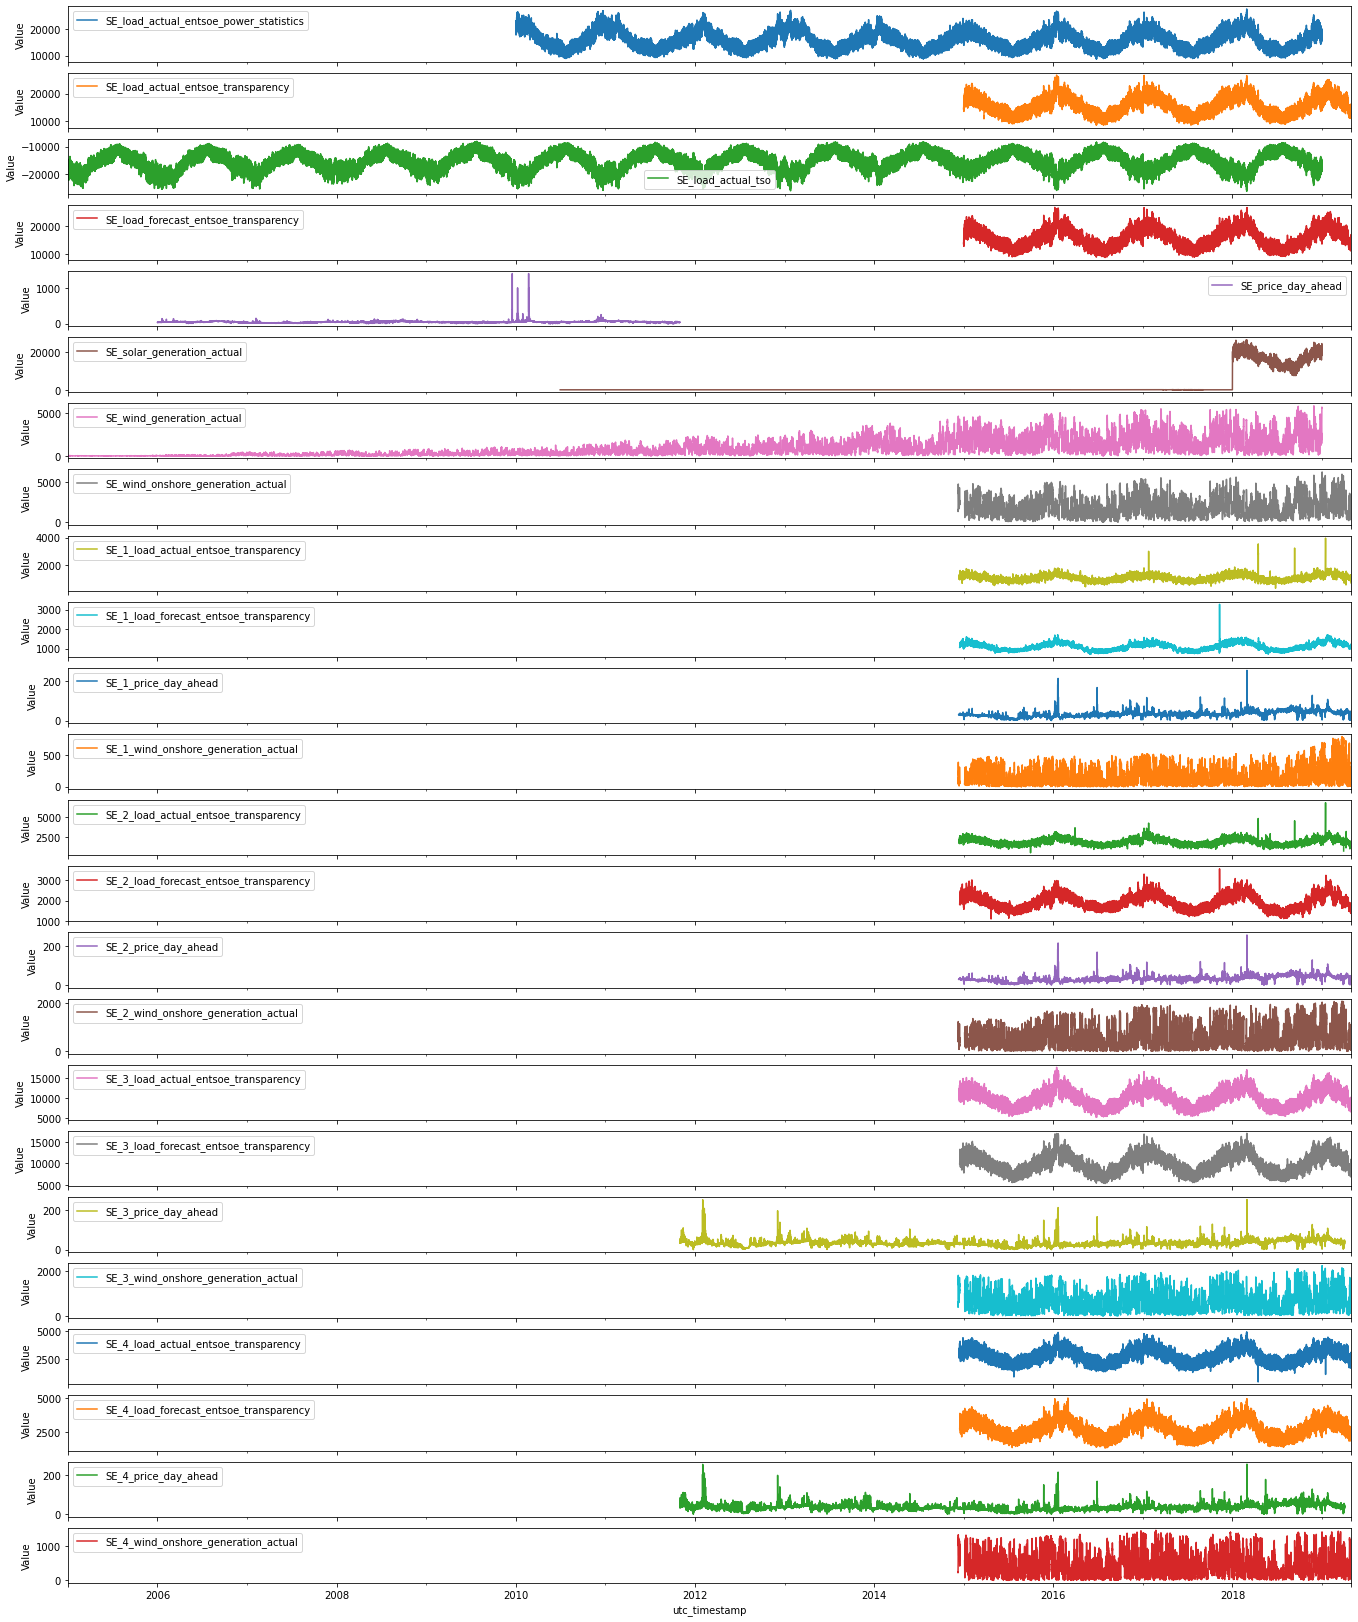

In [388]:
# Plotting timeseries
df_ts.plot(subplots = True, figsize = (23,29), ylabel = 'Value')
plt.show()

## Treatment of NaNs

NaNs at the start of the time series should not be touched, as this implies uncollected data. We cannot now that the time series even existed prior to the first data point.

Therefore NaNs will only be treated within the timeseries. Various methods can be used to interpolate null values in a timeseries, but I will use forward filling linear interpolation based on the time intervals, where effectively the linear mid-point between two known values is used to find the interior point.

With equal time intervals, this method is effectively equivalent to standard linear interpolation.

In [313]:
# Interpolate NaNs in all series
df_ts_filled = df_ts.interpolate(method ='time', limit_direction = 'forward', limit = 5)

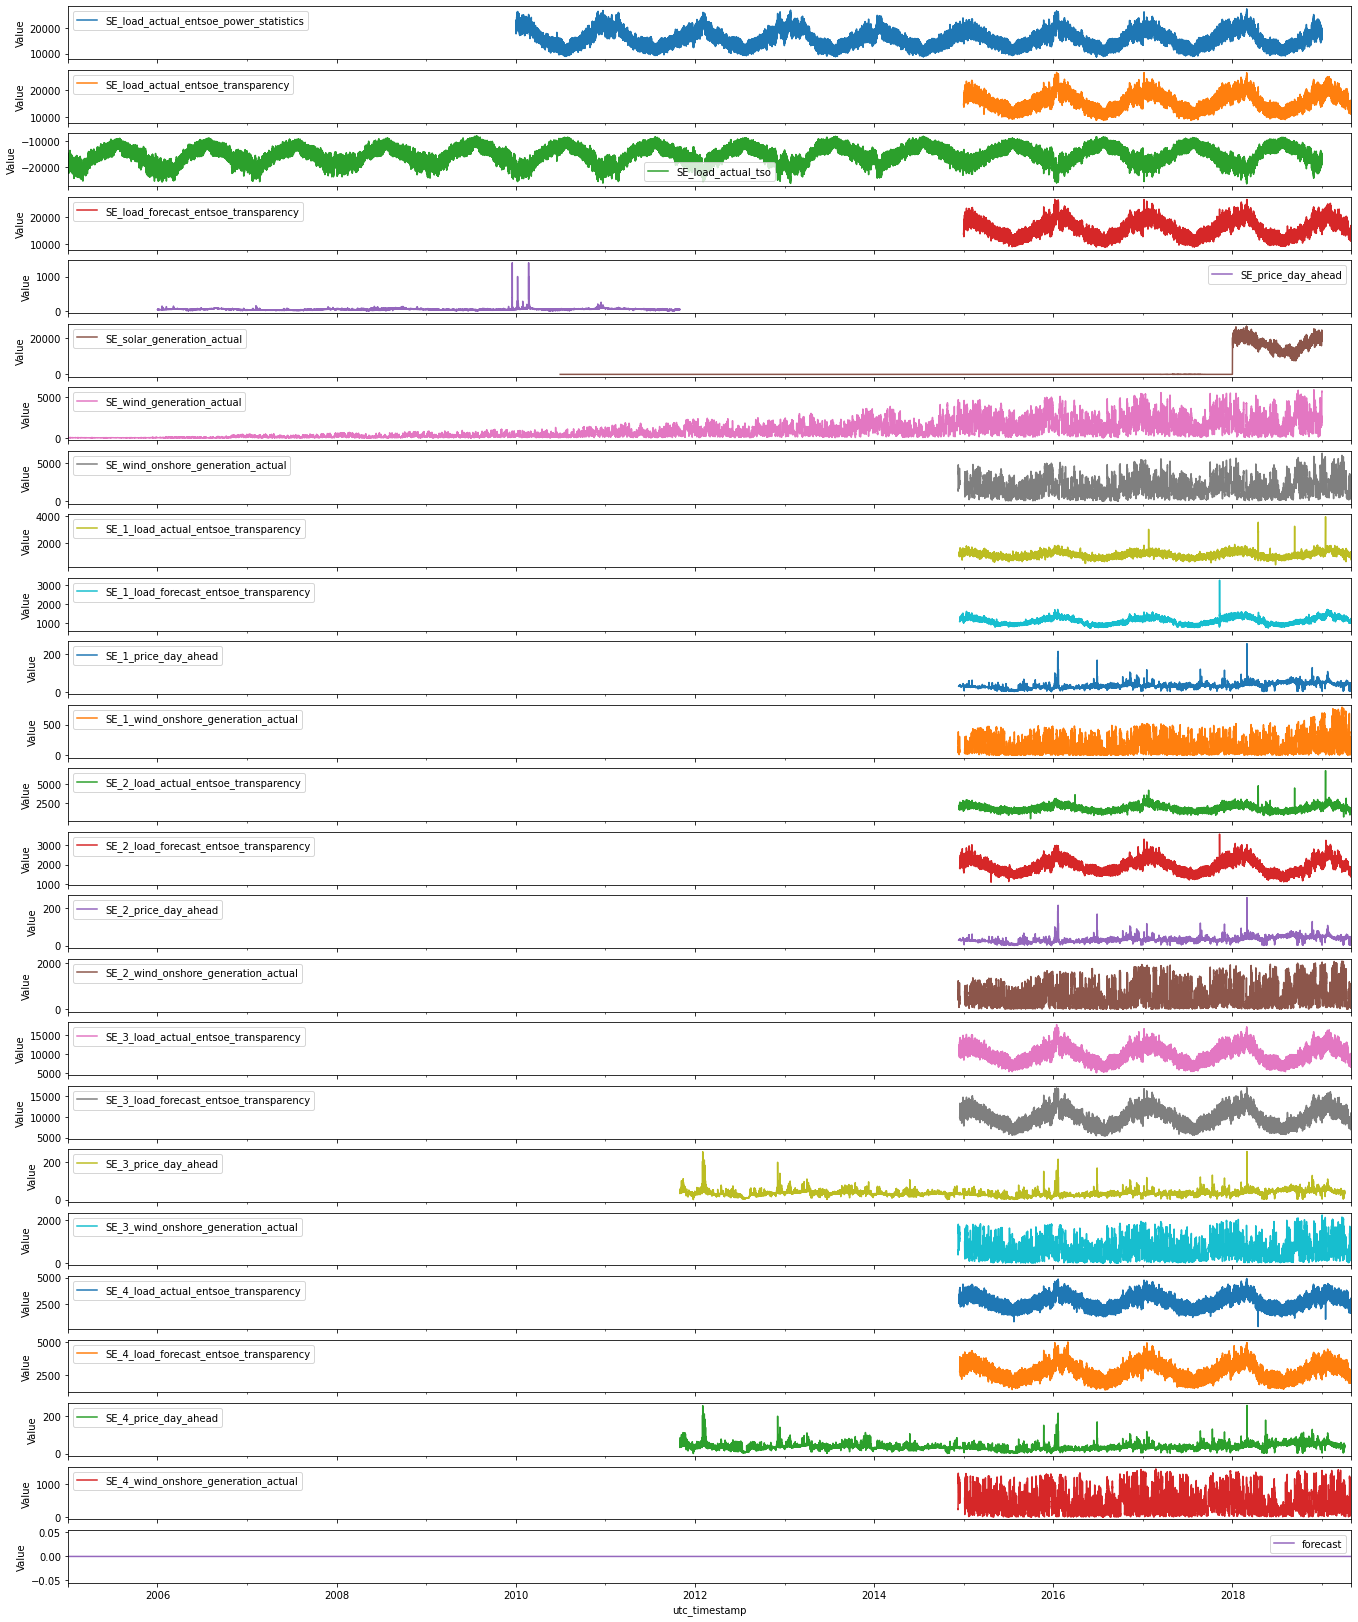

In [387]:
# Plotting timeseries
df_ts_filled.plot(subplots = True, figsize = (23,29), ylabel = 'Value')
plt.show()

## Moving average prediction

In [317]:
# Create the date indexes we will need
dt_index = pd.date_range(start='2019-05-01 00:00:00+00:00', end='2019-05-07 23:00:00+00:00', freq = 'H')

In [318]:
# Get our time series columns
df_columns = df_ts_filled.columns.to_list()

In [319]:
# Create an empty dataframe to fill with predictions
df_pred = pd.DataFrame(index = dt_index, columns = df_columns )

In [320]:
# Adding a label to forecasted values
df_pred['forecast'] = 1

In [321]:
df_ts_filled['forecast'] = 0

In [322]:
# Concatenate the dataframes
df_all = df_ts_filled.append(df_pred)

In [202]:
df_all.index.get_loc('2019-05-01 01:00:00+00:00')

125594

In [385]:
df_len = len(df_all)

In [325]:
# Find rolling mean

# Find the last non-NA value for each series
df_valid = df_all.apply(pd.Series.last_valid_index)

# Last valid index for all series is datetime: 2019-05-01 01:00:00+00:00

for col in df_columns:
    
    # Datetime last non-NA
    dt_NA = df_valid[col]
    
    # Get finishing index
    index = df_all.index.get_loc(dt_NA)
    
    # Get range
    rang = df_len - index - 1
    
    # Isolate series
    ser_cur = df_all[col]
    
    for i in range(0, rang):
        
        # Start filling
        ser_cur[i + 1 + index] = (ser_cur[i + index] + ser_cur[i - 1 + index] + ser_cur[i - 2 + index])/3
          
    df_all[col] = ser_cur
    

SE_load_actual_entsoe_power_statistics
2019-01-01 02:00:00+00:00
122715
3045


/Users/sammacintyre/Documents/Careers/Analysis Tasks/Siemens Energy/sie-2021/siemens-ds-coding-test/venv/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SE_load_actual_entsoe_transparency
2019-04-30 23:00:00+00:00
125592
168
SE_load_actual_tso
2019-01-01 02:00:00+00:00
122715
3045
SE_load_forecast_entsoe_transparency
2019-04-30 23:00:00+00:00
125592
168
SE_price_day_ahead
2011-11-01 02:00:00+00:00
59883
65877
SE_solar_generation_actual
2019-01-01 02:00:00+00:00
122715
3045
SE_wind_generation_actual
2019-01-01 02:00:00+00:00
122715
3045
SE_wind_onshore_generation_actual
2019-04-30 23:00:00+00:00
125592
168
SE_1_load_actual_entsoe_transparency
2019-04-30 23:00:00+00:00
125592
168
SE_1_load_forecast_entsoe_transparency
2019-04-30 23:00:00+00:00
125592
168
SE_1_price_day_ahead
2019-04-30 23:00:00+00:00
125592
168
SE_1_wind_onshore_generation_actual
2019-04-30 23:00:00+00:00
125592
168
SE_2_load_actual_entsoe_transparency
2019-04-30 23:00:00+00:00
125592
168
SE_2_load_forecast_entsoe_transparency
2019-04-30 23:00:00+00:00
125592
168
SE_2_price_day_ahead
2019-04-30 23:00:00+00:00
125592
168
SE_2_wind_onshore_generation_actual
2019-04-30 23:0

<AxesSubplot:>

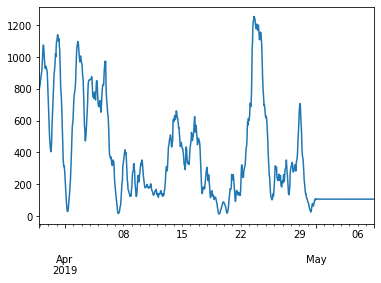

In [383]:
# Check single plot
ser_cur[124800:].plot()

Below we have all timeseries forecasted 7 days (or more) ahead using a 3 period moving average. As we can see, this effectively becomes a constant prediction after a few periods and is not a particularly useful way to predict timeseries evolution.

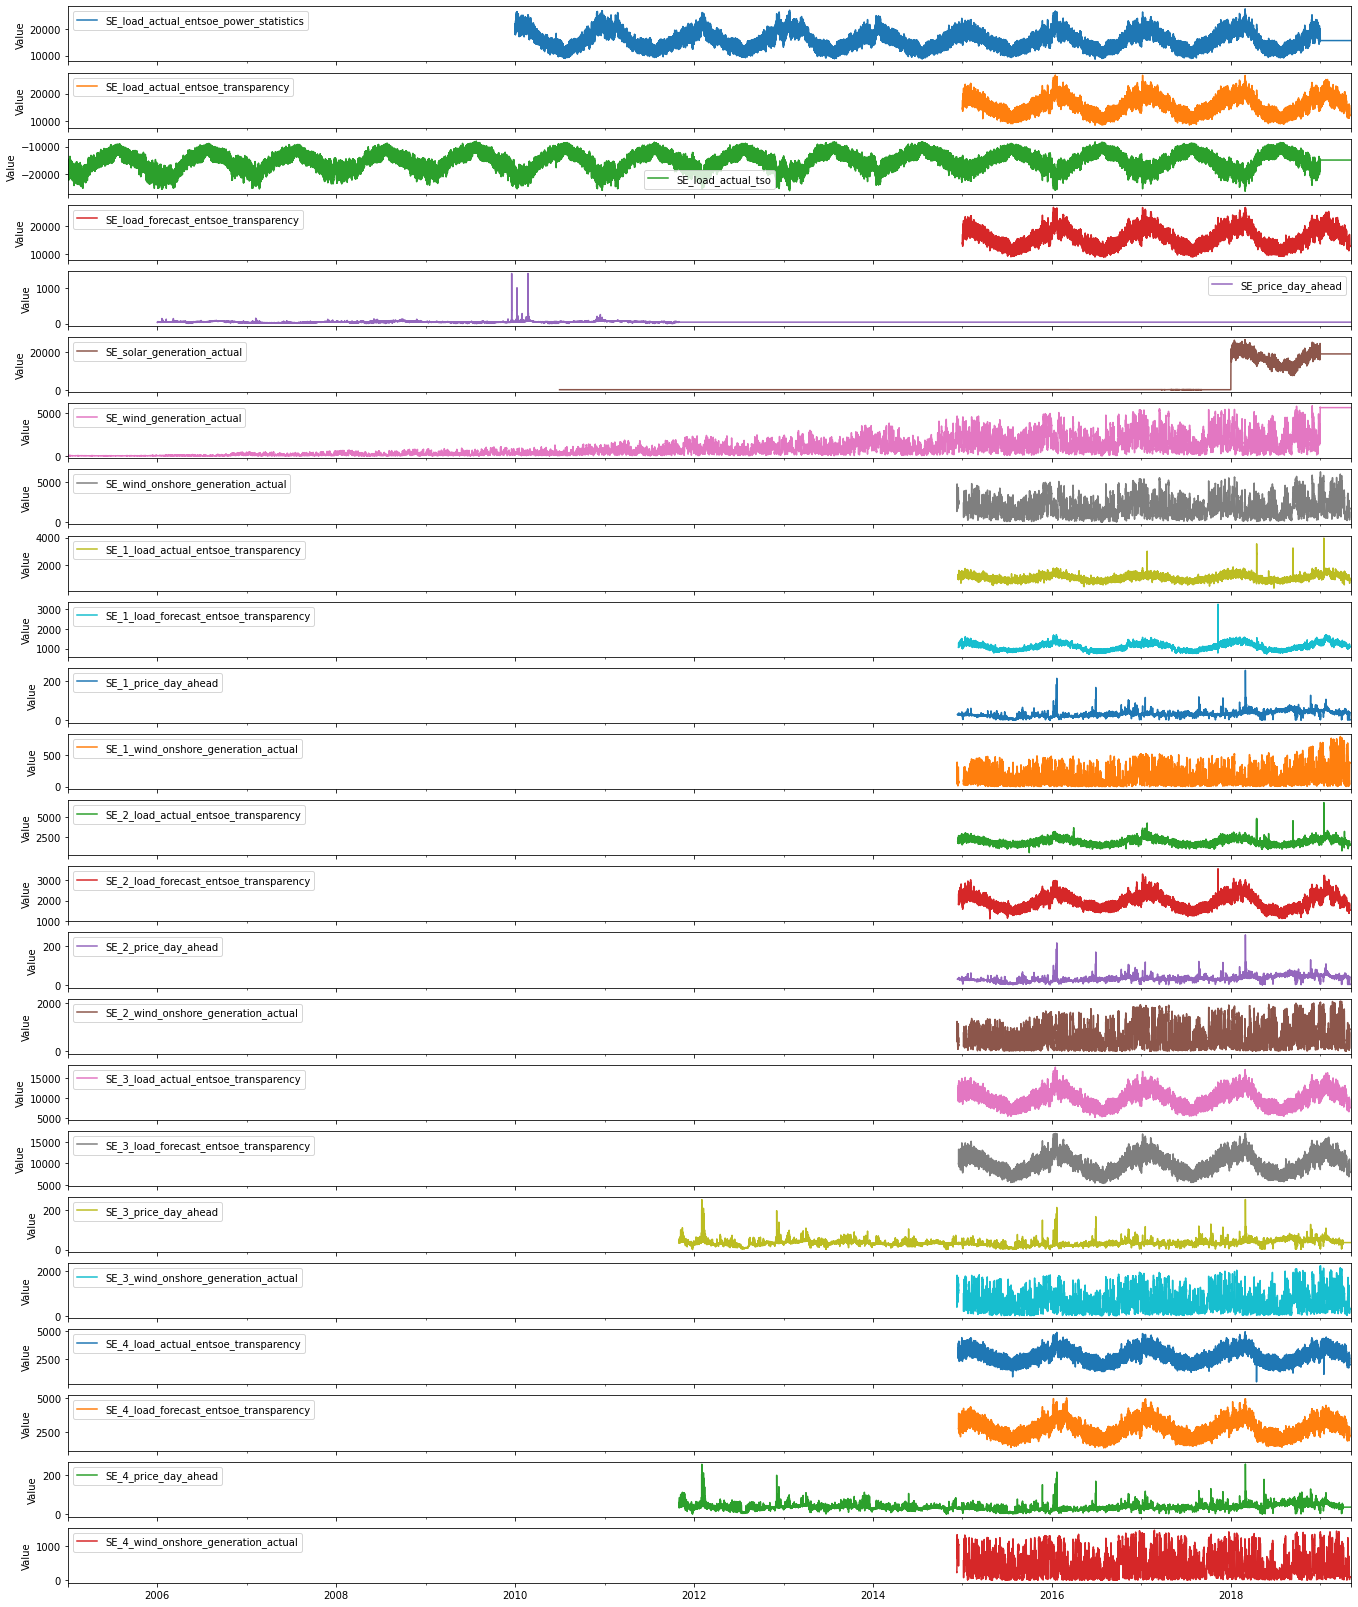

In [382]:
# Plotting timeseries
df = df_all.drop('forecast', axis = 1)
df.plot(subplots = True, figsize = (23,29), ylabel = 'Value')
plt.savefig('Task1_Lineplot.png', facecolor = 'w')

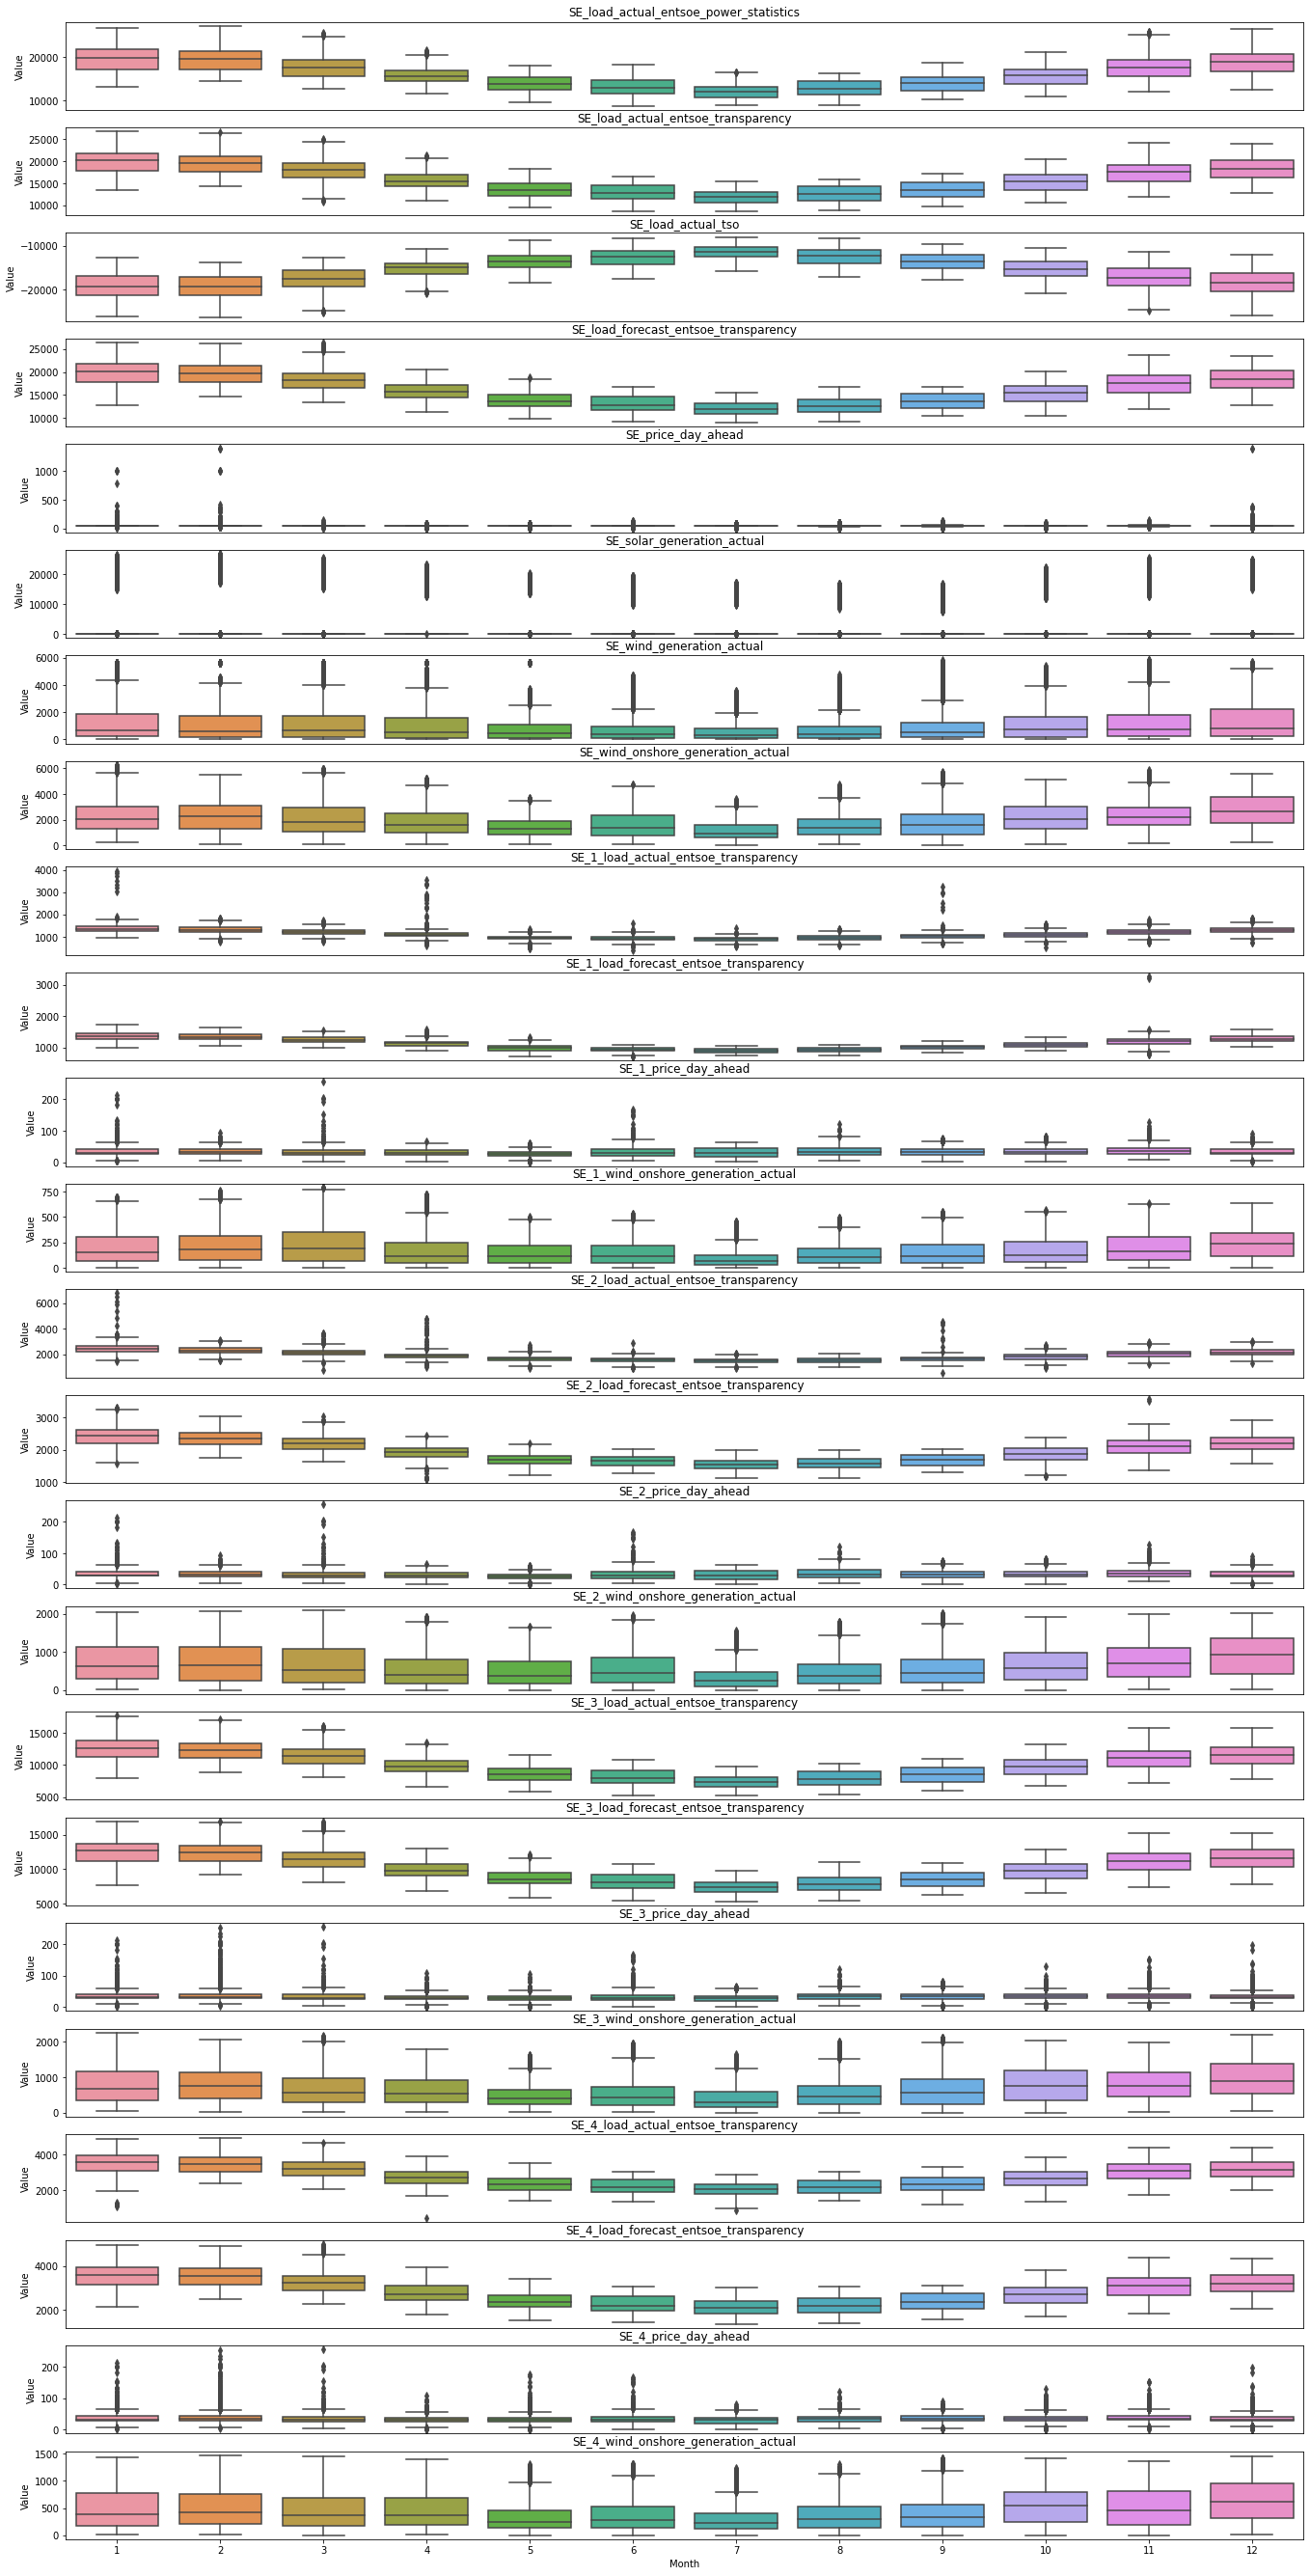

In [372]:
# Reproducing boxplot
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

fig, axes = plt.subplots(24, 1, figsize=(23,48))
i = 0
for col in df_columns:
    box = seaborn.boxplot(x = df_all.index.month, y = df_all[col], ax=axes[i])
    box.set(title = col, ylabel = "Value", xlabel = "Month")
    if(i != 23):
        box.set(xticklabels=[]) 
        box.set(xlabel=None)
        box.tick_params(bottom=False) 
    
        
    i += 1

plt.savefig('Task1_Boxplot.png', facecolor = 'w')

## Discussion and unfinished example of proper treatment

Proper treatment of these time series would involve treating each one separately. Then we would need to follow standard time series practice by investigating trends, seasonality and stationarity. 

Possible models that could be employed:

- ARIMA: Autoregressive and Moving average components
    
- SARIMA: Includes seasonality also
    
- VAR: Includes the values of the other time series, leveraging their relatedness


For each series, we need to produce hourly moving average predictions up to 7 days in the future. Let's begin with one series.

In [136]:
df_single = df_ts_filled['SE_load_actual_entsoe_transparency']

In [137]:
df_single

utc_timestamp
2004-12-31 23:00:00+00:00        NaN
2005-01-01 00:00:00+00:00        NaN
2005-01-01 01:00:00+00:00        NaN
2005-01-01 02:00:00+00:00        NaN
2005-01-01 03:00:00+00:00        NaN
                              ...   
2019-04-30 19:00:00+00:00    13463.0
2019-04-30 20:00:00+00:00    12928.0
2019-04-30 21:00:00+00:00    12110.0
2019-04-30 22:00:00+00:00    12072.0
2019-04-30 23:00:00+00:00    12072.0
Freq: H, Name: SE_load_actual_entsoe_transparency, Length: 125593, dtype: float64

In [138]:
df_single.dropna(how = 'all', inplace = True)

<AxesSubplot:xlabel='utc_timestamp'>

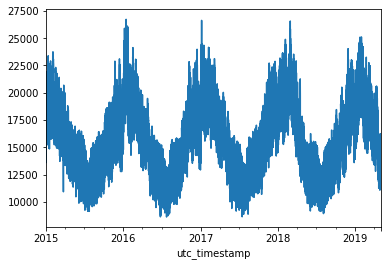

In [139]:
df_single.plot()

In [141]:
df_single.index

DatetimeIndex(['2015-01-01 00:00:00+00:00', '2015-01-01 01:00:00+00:00',
               '2015-01-01 02:00:00+00:00', '2015-01-01 03:00:00+00:00',
               '2015-01-01 04:00:00+00:00', '2015-01-01 05:00:00+00:00',
               '2015-01-01 06:00:00+00:00', '2015-01-01 07:00:00+00:00',
               '2015-01-01 08:00:00+00:00', '2015-01-01 09:00:00+00:00',
               ...
               '2019-04-30 14:00:00+00:00', '2019-04-30 15:00:00+00:00',
               '2019-04-30 16:00:00+00:00', '2019-04-30 17:00:00+00:00',
               '2019-04-30 18:00:00+00:00', '2019-04-30 19:00:00+00:00',
               '2019-04-30 20:00:00+00:00', '2019-04-30 21:00:00+00:00',
               '2019-04-30 22:00:00+00:00', '2019-04-30 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='utc_timestamp', length=37944, freq='H')

It is important to note here that this time series is not stationary, and displays strong seasonality. A simple moving average prediction will be rather poor. In fact, each time series deserves its own treatment, as we can many examples of non-stationary (particularly seasonal behaviour). The task only asked for Moving Average predictions, so we will begin with an MA model as a base, although the predictions may be poor.

Below, we are investigating the PACF and ACF to guide how many lags to use in the MA model. The seasonality almost makes this analysis invalid, but we will use 2 based on the PACF graph. 

/Users/sammacintyre/Documents/Careers/Analysis Tasks/Siemens Energy/sie-2021/siemens-ds-coding-test/venv/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


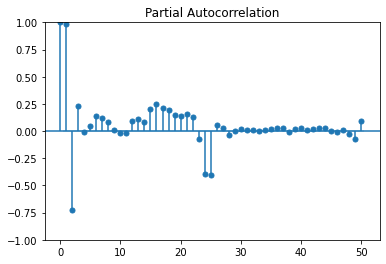

In [142]:
plot_pacf(df_single, lags = 50)
plt.show()

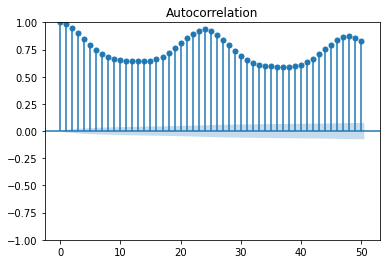

In [143]:
plot_acf(df_single, lags = 50)
plt.show()

In [144]:
model = ARIMA(df_single, order = (0, 0, 2))

In [145]:
results = model.fit()
results.summary()

/Users/sammacintyre/Documents/Careers/Analysis Tasks/Siemens Energy/sie-2021/siemens-ds-coding-test/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:     SE_load_actual_entsoe_transparency   No. Observations:                37944
Model:                                 ARIMA(0, 0, 2)   Log Likelihood             -318240.622
Date:                                Sat, 20 Nov 2021   AIC                         636489.244
Time:                                        15:17:35   BIC                         636523.420
Sample:                                    01-01-2015   HQIC                        636500.089
                                         - 04-30-2019                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.584e+04     19.519    811.303      0.000    1.58e+04    1.59e+04
ma.L1          1.6550      0.001   1238.129      0.000       1.652       1.658
ma.L2          0.8538      0.001    622.511      0.000       0.851       0.856
sigma2      1.128e+06   6777.045    166.487      0.000    1.12e+06    1.14e+06
===================================================================================
Ljung-Box (L1) (Q):               18622.41   Jarque-Bera (JB):             10986.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMAX approach - example start



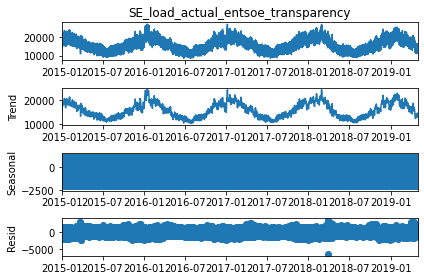

In [147]:
# Decompose seasonally
decompose_data = seasonal_decompose(df_single, model="additive")
decompose_data.plot()
plt.show()

<AxesSubplot:xlabel='utc_timestamp'>

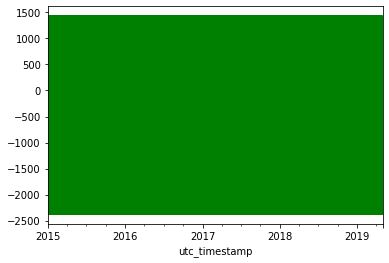

In [148]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')